In [1]:
# Standard Library Imports
import os
import sys
from typing import List, Any, Callable, Union, Tuple, Optional
from importlib import reload

# Third-Party Library Imports
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cf
from pprint import pprint
from functools import partial
from glob import glob
import cftime
import json
import string

# Custom Module Imports
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'PhD'))
import constants
sys.path.append(constants.MODULE_DIR)
import open_ds
import open_zecmip
import utils
import signal_to_noise as sn
import plotting_functions
import xarray_extender as xe
import zec_calculation_functions
import drift_functions
import sn_plotting
import stats

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

# Logging
logger = utils.get_notebook_logger()

In [2]:
import listXarray as lxr
reload(lxr)
from listXarray import listXarray

# Opening Data

In [3]:
a1_raw_xrlist = (open_zecmip.extract_experiment_into_xrlist('1000pgc', 'tas', logginglevel='ERROR')
                 .to_dataarray('tas')
                 .sort_by_refkey())

In [4]:
pct_raw_xrlist =  (open_zecmip.extract_experiment_into_xrlist('1pct', 'tas')
                   .to_dataarray('tas')
                   .sort_by_refkey())

In [5]:
esmpi_raw_xrlist = (open_zecmip.extract_experiment_into_xrlist('esm-piControl', 'tas', logginglevel='INFO')
                    .to_dataarray('tas')
                    .isel(ensemble=0)
                    .squeeze('ensemble')
                    .sort_by_refkey()
                    .rename({'latitude':'lat', 'longitude': 'lon'}))

- ACCESS-ESM1-5
- r1i1p1f1 - /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/esm-piControl/r1i1p1f1/Amon/tas/gn/v20191115/*.nc
- CanESM5
- r1i1p1f1 - /g/data/oi10/replicas/CMIP6/CMIP/CCCma/CanESM5/esm-piControl/r1i1p1f1/Amon/tas/gn/v20190429/*.nc
- MIROC-ES2L
- r1i1p1f2 - /g/data/oi10/replicas/CMIP6/CMIP/MIROC/MIROC-ES2L/esm-piControl/r1i1p1f2/Amon/tas/gn/v20200428/*.nc
- UKESM1-0-LL
- r1i1p1f1 - /g/data/w40/ab2313/PhD/zecmip/original/esm_picontrol/UKESM1-0-LL/*.nc
- MPI-ESM1-2-LR
- r1i1p1f1 - /g/data/oi10/replicas/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/esm-piControl/r1i1p1f1/Amon/tas/gn/v20190815/*.nc
- GISS-E2-1-G-CC
- r1i1p1f1 - /g/data/w40/ab2313/PhD/zecmip/original/esm_picontrol/GISS/*.nc
- CESM2
- r1i1p1f1 - /g/data/oi10/replicas/CMIP6/CMIP/NCAR/CESM2/esm-piControl/r1i1p1f1/Amon/tas/gn/v20190723/*.nc
- NorESM2-LM
- r1i1p1f1 - /g/data/oi10/replicas/CMIP6/CMIP/NCC/NorESM2-LM/esm-piControl/r1i1p1f1/Amon/tas/gn/v20190920/*.nc
- GFDL-ESM4
- r1i1p1f1 - /g/data/oi10/replicas/CMIP6/CMIP

In [6]:
# Match all the ensemble dimensions
pct_raw_xrlist = pct_raw_xrlist.cross_match_dim(a1_raw_xrlist, 'ensemble')
a1_raw_xrlist = a1_raw_xrlist.cross_match_dim(pct_raw_xrlist, 'ensemble')

# Global Mean Calculation

In [7]:
# Convert to celcius
# a1_raw_xrlist = a1_raw_xrlist - 273.15
# pct_raw_xrlist = pct_raw_xrlist - 273.15
# esmpi_raw_xrlist = esmpi_raw_xrlist - 273.15

In [8]:
# Making the data yearly
esmpi_xrlist = esmpi_raw_xrlist.resample(time='Y').mean(dim='time').set_refkeys('model')
pct_xrlist = pct_raw_xrlist.resample(time='Y').mean(dim='time').set_refkeys('model')
a1_xrlist = a1_raw_xrlist.resample(time='Y').mean(dim='time').set_refkeys('model')

In [9]:
# Subsetting to only first 150 years so all models have equal footing
esmpi_xrlist = esmpi_xrlist.isel(time=slice(None, 150))

# Reduce time so that the smalles time densions matches. This is at 101 years
a1_xrlist = a1_xrlist.isel(time=slice(None, 101))
esmpi_xrlist

key_dim = model


Number of da/ds: 9
---------------
['ACCESS-ESM1-5']({'model': 1, 'time': 150, 'lat': 145, 'lon': 192})
['CESM2']       ({'model': 1, 'time': 150, 'lat': 192, 'lon': 288})
['CanESM5']     ({'model': 1, 'time': 150, 'lat': 64, 'lon': 128})
['GFDL-ESM4']   ({'model': 1, 'time': 150, 'lat': 180, 'lon': 288})
['GISS-E2-1-G-CC']({'model': 1, 'time': 150, 'lat': 90, 'lon': 144})
['MIROC-ES2L']  ({'model': 1, 'time': 150, 'lat': 64, 'lon': 128})
['MPI-ESM1-2-LR']({'model': 1, 'time': 150, 'lat': 96, 'lon': 192})
['NorESM2-LM']  ({'model': 1, 'time': 150, 'lat': 96, 'lon': 144})
['UKESM1-0-LL'] ({'model': 1, 'time': 150, 'lat': 144, 'lon': 192})

In [10]:
# # The global weighted mean
# pct_smean_xrlist = pct_xrlist.apply(sn.calculate_global_value, 'tas').compute()
# a1_smean_xrlist = a1_xrlist.apply(sn.calculate_global_value, 'tas').compute()
# esmpi_smean_xrlist = esmpi_xrlist.apply(sn.calculate_global_value, 'tas').compute()

In [11]:
# Calculate the values at the branching point
branch_point_mean_xrlist = listXarray([zec_calculation_functions.calculate_branch_average(
    pct_xrlist[model], a1_xrlist[model], logginglevel='INFO') for model in pct_xrlist.refkeys])

branch_point_mean_xrlist = branch_point_mean_xrlist.set_refkeys('model')

- ['ACCESS-ESM1-5'] - ['ACCESS-ESM1-5']
- branch_start_time=cftime.DatetimeProlepticGregorian(168, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=67
- 

- ['CESM2'] - ['CESM2']
- branch_start_time=cftime.DatetimeNoLeap(68, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=67
- 

- ['CanESM5'] - ['CanESM5']
- branch_start_time=cftime.DatetimeNoLeap(1911, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=61
- 

- ['GFDL-ESM4'] - ['GFDL-ESM4']
- branch_start_time=cftime.DatetimeNoLeap(64, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=63
- 

- ['GISS-E2-1-G-CC'] - ['GISS-E2-1-G-CC']
- branch_start_time=cftime.DatetimeNoLeap(1920, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=70
- 

- ['MIROC-ES2L'] - ['MIROC-ES2L']
- branch_start_time=cftime.DatetimeGregorian(1913, 12, 31, 0, 0, 0, 0, has_year_zero=False)
- onepct_branch_arg=63
- 

- ['MPI-ESM1-2-LR'] - ['MPI-ESM1-2-LR']
- branch_start_time=cftime.DatetimeProlepticGregorian(1915,

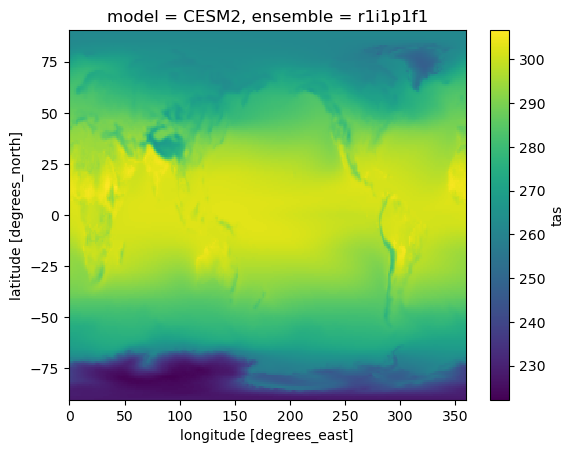

In [12]:
branch_point_mean_xrlist['CESM2'].plot()

In [13]:
# The amomaly time series from the branch point
a1_anom_xrlist = (a1_xrlist - branch_point_mean_xrlist).compute()

In [14]:
# This way procudes the same as when you average first then take the anomalies. However, we also get the anomaleis
# time series which is useful
zec25_xrlist = a1_anom_xrlist.isel(time=slice(15, 35)).mean(dim='time')
zec50_xrlist = a1_anom_xrlist.isel(time=slice(40, 60)).mean(dim='time')
zec50_xrlist

key_dim = model


Number of da/ds: 9
---------------
['ACCESS-ESM1-5']({'ensemble': 1, 'model': 1, 'lat': 145, 'lon': 192})
['CESM2']       ({'ensemble': 1, 'model': 1, 'lat': 192, 'lon': 288})
['CanESM5']     ({'ensemble': 3, 'model': 1, 'lat': 64, 'lon': 128})
['GFDL-ESM4']   ({'ensemble': 1, 'model': 1, 'lat': 180, 'lon': 288})
['GISS-E2-1-G-CC']({'ensemble': 1, 'model': 1, 'lat': 90, 'lon': 144})
['MIROC-ES2L']  ({'ensemble': 1, 'model': 1, 'lat': 64, 'lon': 128})
['MPI-ESM1-2-LR']({'ensemble': 1, 'model': 1, 'lat': 96, 'lon': 192})
['NorESM2-LM']  ({'ensemble': 1, 'model': 1, 'lat': 96, 'lon': 144})
['UKESM1-0-LL'] ({'ensemble': 4, 'model': 1, 'lat': 144, 'lon': 192})

In [15]:
a1_anom_xrlist = a1_anom_xrlist.apply(utils.reset_time_to_0_start)
esmpi_xrlist = esmpi_xrlist.apply(utils.reset_time_to_0_start)

In [16]:
esmpi_xrlist

key_dim = model


Number of da/ds: 9
---------------
['ACCESS-ESM1-5']({'model': 1, 'time': 150, 'lat': 145, 'lon': 192})
['CESM2']       ({'model': 1, 'time': 150, 'lat': 192, 'lon': 288})
['CanESM5']     ({'model': 1, 'time': 150, 'lat': 64, 'lon': 128})
['GFDL-ESM4']   ({'model': 1, 'time': 150, 'lat': 180, 'lon': 288})
['GISS-E2-1-G-CC']({'model': 1, 'time': 150, 'lat': 90, 'lon': 144})
['MIROC-ES2L']  ({'model': 1, 'time': 150, 'lat': 64, 'lon': 128})
['MPI-ESM1-2-LR']({'model': 1, 'time': 150, 'lat': 96, 'lon': 192})
['NorESM2-LM']  ({'model': 1, 'time': 150, 'lat': 96, 'lon': 144})
['UKESM1-0-LL'] ({'model': 1, 'time': 150, 'lat': 144, 'lon': 192})

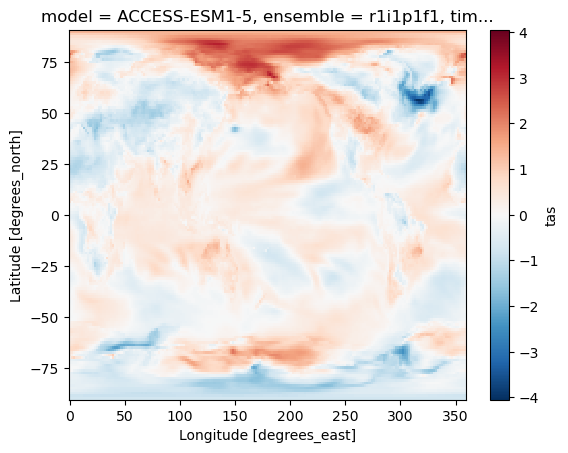

In [17]:
a1_anom_xrlist.single_xarray(0).isel(model=0, ensemble=0, time=0).plot()

# SN Calculation

In [18]:
# Detrend the data
a1_anom_trendfit_xrlist = a1_anom_xrlist.apply(stats.trend_fit, method='polynomial', order=3)
a1_anom_detrend_xrlist = a1_anom_xrlist - a1_anom_trendfit_xrlist

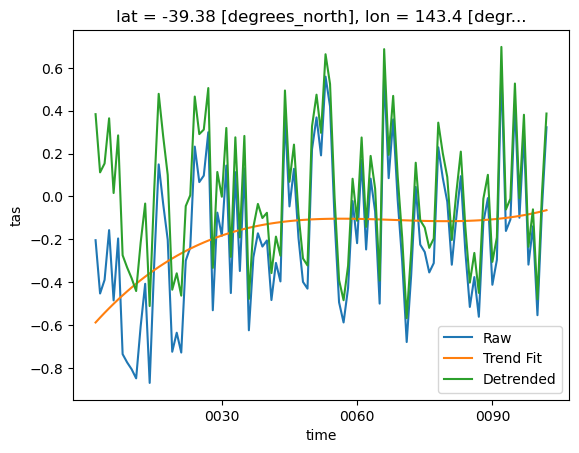

In [19]:
model = 'UKESM1-0-LL'#'CESM2'
ensemble=1
a1_anom_xrlist[model].isel(ensemble=ensemble).sel(lat=-39, lon=144, method='nearest').plot(label='Raw')
a1_anom_trendfit_xrlist[model].isel(ensemble=ensemble).sel(lat=-39, lon=144, method='nearest').plot(label='Trend Fit')
a1_anom_detrend_xrlist[model].isel(ensemble=ensemble).sel(lat=-39, lon=144, method='nearest').plot(label='Detrended')
plt.legend()

In [20]:
constants.ZECMIP_MULTI_WINDOW_RUN_PARAMS

{'start_window': 10, 'end_window': 41, 'step_window': 1}

In [21]:
a1_anom_detrend_xrlist.unify_chunks()

key_dim = model


Number of da/ds: 9
---------------
['ACCESS-ESM1-5']({'ensemble': 1, 'model': 1, 'time': 101, 'lat': 145, 'lon': 192})
['CESM2']       ({'ensemble': 1, 'model': 1, 'time': 101, 'lat': 192, 'lon': 288})
['CanESM5']     ({'ensemble': 3, 'model': 1, 'time': 100, 'lat': 64, 'lon': 128})
['GFDL-ESM4']   ({'ensemble': 1, 'model': 1, 'time': 101, 'lat': 180, 'lon': 288})
['GISS-E2-1-G-CC']({'ensemble': 1, 'model': 1, 'time': 101, 'lat': 90, 'lon': 144})
['MIROC-ES2L']  ({'ensemble': 1, 'model': 1, 'time': 101, 'lat': 64, 'lon': 128})
['MPI-ESM1-2-LR']({'ensemble': 1, 'model': 1, 'time': 101, 'lat': 96, 'lon': 192})
['NorESM2-LM']  ({'ensemble': 1, 'model': 1, 'time': 100, 'lat': 96, 'lon': 144})
['UKESM1-0-LL'] ({'ensemble': 4, 'model': 1, 'time': 101, 'lat': 144, 'lon': 192})

In [22]:
# Having these persisted should 'hopefully' save time
a1_anom_xrlist = a1_anom_xrlist.persist()
esmpi_xrlist = esmpi_xrlist.persist()
a1_anom_detrend_xrlist = a1_anom_detrend_xrlist.persist()

In [26]:
%%time
# Calculate thje rolling and non rolling signal to noise
sn_multi_rolling_xrlist = listXarray([sn.multiwindow_signal_to_nosie_and_bounds(
    a1_anom_xrlist[model], esmpi_xrlist[model].drop('ensemble'),
    da_for_noise=a1_anom_detrend_xrlist[model],
    rolling_noise=True, windows=[20, 40],return_all=True, logginglevel='ERROR') for model in a1_anom_xrlist.refkeys]).set_refkeys('model').compute()


Experiment
--------
20, 40, 
Concatenating objects - PLEASE be patient!
 - Finished

Control
------

20, 40, 
Concatenating objects - PLEASE be patient!
Persist
Calculating bounds
final merge

Experiment
--------
20, 40, 
Concatenating objects - PLEASE be patient!
 - Finished

Control
------

20, 40, 
Concatenating objects - PLEASE be patient!
Persist
Calculating bounds
final merge

Experiment
--------
20, 40, 
Concatenating objects - PLEASE be patient!
 - Finished

Control
------

20, 40, 
Concatenating objects - PLEASE be patient!
Persist
Calculating bounds
final merge

Experiment
--------
20, 40, 
Concatenating objects - PLEASE be patient!
 - Finished

Control
------

20, 40, 
Concatenating objects - PLEASE be patient!
Persist
Calculating bounds
final merge

Experiment
--------
20, 40, 
Concatenating objects - PLEASE be patient!
 - Finished

Control
------

20, 40, 
Concatenating objects - PLEASE be patient!
Persist
Calculating bounds
final merge

Experiment
--------
20, 40, 
Conca

In [27]:
sn_multi_rolling_xrlist

key_dim = model


Number of da/ds: 9
---------------
ACCESS-ESM1-5   ({'lat': 145, 'lon': 192, 'time': 101, 'window': 2})
CESM2           ({'lat': 192, 'lon': 288, 'time': 101, 'window': 2})
CanESM5         ({'lat': 64, 'lon': 128, 'ensemble': 3, 'time': 100, 'window': 2})
GFDL-ESM4       ({'lat': 180, 'lon': 288, 'time': 101, 'window': 2})
GISS-E2-1-G-CC  ({'lat': 90, 'lon': 144, 'time': 101, 'window': 2})
MIROC-ES2L      ({'lat': 64, 'lon': 128, 'time': 101, 'window': 2})
MPI-ESM1-2-LR   ({'lat': 96, 'lon': 192, 'time': 101, 'window': 2})
NorESM2-LM      ({'lat': 96, 'lon': 144, 'time': 100, 'window': 2})
UKESM1-0-LL     ({'lat': 144, 'lon': 192, 'ensemble': 4, 'time': 101, 'window': 2})

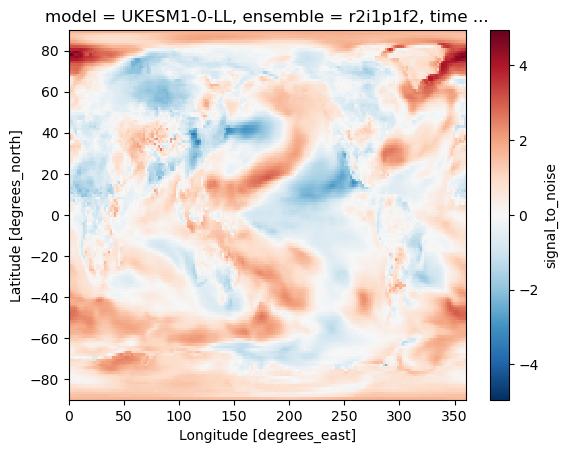

In [28]:
sn_multi_rolling_xrlist['UKESM1-0-LL'].signal_to_noise.isel(ensemble=1, window=0, time=0).plot()

In [29]:
# THis is only needed for the bounds on the RHS plots for the supp all model patterns plot
# sn_multi_rolling_ds = sn_multi_rolling_xrlist.mean(dim='ensemble').drop('ensemble').concat('model')

In [30]:
# This is the length that all of the plots shoudl go to
max_effective_length = len(sn_multi_rolling_xrlist.dim('time', output='dict')['CanESM5']) - constants.ZECMIP_MULTI_WINDOW_RUN_PARAMS['end_window']
max_effective_length

59

In [31]:
# Calculate the year that each is stable
rolling_year_stable_xrlist = sn_multi_rolling_xrlist.apply(sn.get_stable_year_ds, max_effective_length=max_effective_length)
rolling_year_stable_xrlist

key_dim = model


Number of da/ds: 9
---------------
ACCESS-ESM1-5   ({'lat': 145, 'lon': 192, 'window': 2, 'variable': 1})
CESM2           ({'lat': 192, 'lon': 288, 'window': 2, 'variable': 1})
CanESM5         ({'lat': 64, 'lon': 128, 'ensemble': 3, 'window': 2, 'variable': 1})
GFDL-ESM4       ({'lat': 180, 'lon': 288, 'window': 2, 'variable': 1})
GISS-E2-1-G-CC  ({'lat': 90, 'lon': 144, 'window': 2, 'variable': 1})
MIROC-ES2L      ({'lat': 64, 'lon': 128, 'window': 2, 'variable': 1})
MPI-ESM1-2-LR   ({'lat': 96, 'lon': 192, 'window': 2, 'variable': 1})
NorESM2-LM      ({'lat': 96, 'lon': 144, 'window': 2, 'variable': 1})
UKESM1-0-LL     ({'lat': 144, 'lon': 192, 'ensemble': 4, 'window': 2, 'variable': 1})

In [32]:
levels = np.arange(0, 60, 5)

In [33]:
my_cmap = plotting_functions.create_discrete_cmap('BuPu', levels=levels, add_white=True)

In [34]:
model = rolling_year_stable_xrlist.refkeys[-2]
model

'NorESM2-LM'

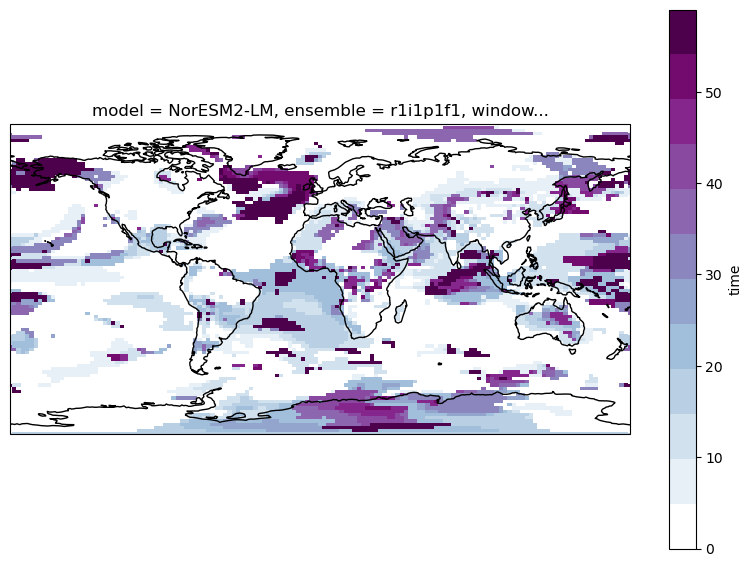

In [35]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
rolling_year_stable_xrlist[model].isel(window=1).time.plot(ax=ax, cmap=my_cmap)
ax.coastlines()

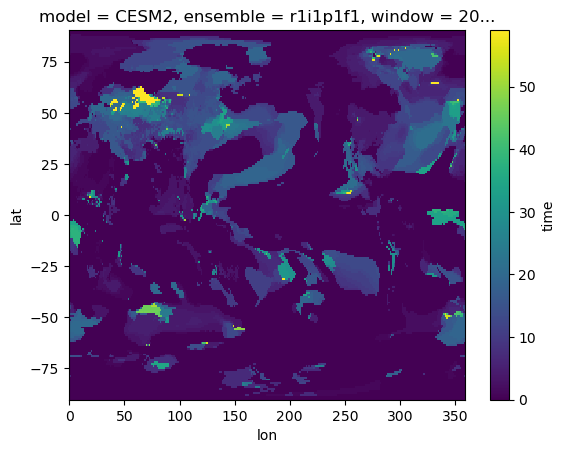

In [36]:
rolling_year_stable_xrlist['CESM2'].isel(window=0).time.plot()

In [37]:
# # # Number of models stable at each time step.
# rolling_stability_levels_ds = sn.stability_levels(sn_multi_rolling_xrlist.mean(dim='ensemble').drop('ensemble').concat('model'))
# static_stability_levels_ds = sn.stability_levels(sn_multi_rolling_xrlist.mean(dim='ensemble').drop('ensemble').concat('model'))

In [38]:
# # Just the unstalgbe points - both xrlist and ds
above_or_below_kwargs = dict(main_var='signal_to_noise', greater_than_var='upper_bound', less_than_var='lower_bound')

unstable_rolling_xrlist = sn_multi_rolling_xrlist.above_or_below(**above_or_below_kwargs)
# unstable_rolling_ds = sn_multi_rolling_xrlist.mean(dim='ensemble').drop('ensemble').concat('model').utils.above_or_below(**above_or_below_kwargs)

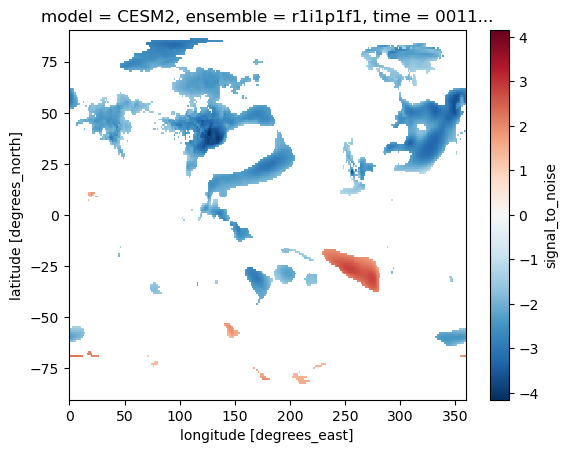

In [39]:
unstable_rolling_xrlist['CESM2'].isel(window=0, time=10).signal_to_noise.plot()

In [40]:
# For each window get the number of years that are stable forn each point in time
decreasing_listxarray = lxr.where(unstable_rolling_xrlist < 0, 1, 0)
decreasing_ds = decreasing_listxarray.sum(dim='ensemble').drop('ensemble').concat('model')#.sum('model')

increasing_listxarray = lxr.where(unstable_rolling_xrlist > 0, 1, 0)
increasing_ds = increasing_listxarray.sum(dim='ensemble').drop('ensemble').concat('model')#.sum('model')

In [44]:
to_concat = []
base_ds = xr.zeros_like(rolling_year_stable_regrid_xrlist.single_xarray().drop('ensemble'))
for model, ds in rolling_year_stable_xrlist:
    ensemble_values = ds.ensemble.values
    if ensemble_values.ndim != 0: ds = ds.sum(dim='ensemble')
    ds = ds.drop('ensemble', errors='ignore')
    base_ds += ds
# base_ds = base_ds/14

NameError: name 'rolling_year_stable_regrid_xrlist' is not defined

In [ ]:
base_ds

In [ ]:
ds.isel(window=0).time.plot()

In [ ]:
base_ds.isel(window=0).time.plot()

In [ ]:
to_concat = []
for model, ds in rolling_year_stable_xrlist:
    ds_mean = ds<0 & np.isfinite(ds), 1, 0)
    ensemble_values = ds.ensemble.values
    if ensemble_values.ndim == 1:
        ds_count = ds_count.sum(dim='ensemble')
    
    ds_count = ds_count.drop('ensemble', errors='ignore')
        
    to_concat.append(ds_count)

decreasing_ds = xr.concat(to_concat, dim='model')

In [ ]:
to_concat = []
for model, ds in unstable_rolling_xrlist:
    ds_count = xr.where(ds>0 & np.isfinite(ds), 1, 0)
    ensemble_values = ds.ensemble.values
    if ensemble_values.ndim == 1:
        ds_count = ds_count.sum(dim='ensemble')
    
    ds_count = ds_count.drop('ensemble', errors='ignore')
        
    to_concat.append(ds_count)

increasing_ds = xr.concat(to_concat, dim='model')